In [0]:
import pyspark as sp
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,date_format,concat,substring,lit,lpad,to_timestamp,when
import  pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import month, dayofmonth, to_date

In [0]:
spark = SparkSession.builder.getOrCreate()

In [0]:
df=spark.read.option("header","true").option("inferSchema", "true").csv("dbfs:/FileStore/2018_039620.csv")

In [0]:
df = df.withColumn("lat", df["lat"] / 1000)


In [0]:
df = df.withColumn("long", df["long"] / 1000)

In [0]:
df = df.withColumn("airtemp", df["airtemp"] / 10)

In [0]:
df = df.withColumn("dewpointtemp", df["dewpointtemp"] / 10)

In [0]:
df = df.withColumn("atmpress", df["atmpress"] / 10)

In [0]:
df = df.withColumn("date", 
                   concat(substring(col("date"), 1, 4), 
                          lit("-"), 
                          substring(col("date"), 5, 2), 
                          lit("-"), 
                          substring(col("date"), 7, 2)))

In [0]:
df = df.withColumn("time", lpad(col("time"), 4, "0"))

In [0]:
df = df.withColumn("time", 
                   concat(substring(col("time"), 1, 2), 
                          lit(":"),
                          substring(col("time"), 3, 2)))

In [0]:
df = df.withColumn("timestamp", to_timestamp(concat(col("date"), lit(" "), col("time")), "yyyy-MM-dd HH:mm"))

In [0]:
def get_season(month):
    if 3 <= month <= 5:
        return "Spring"
    elif 6 <= month <= 8:
        return "Summer"
    elif 9 <= month <= 11:
        return "Autumn"
    else:
        return "Winter"

In [0]:
df = df.withColumn("month", col("date").substr(6, 2).cast("int"))
df = df.withColumn("season", when((col("month") >= 3) & (col("month") <= 5), "Spring")
                              .when((col("month") >= 6) & (col("month") <= 8), "Summer")
                              .when((col("month") >= 9) & (col("month") <= 11), "Autumn")
                              .otherwise("Winter"))

In [0]:
season_day_agg = df.groupBy("season", "date").agg(
    {"airtemp": "avg", "visdist": "avg", "winddir":"avg","atmpress":"avg",}  # Add other attributes as needed
)


# Sort the aggregated DataFrame by season, date
season_day_agg_sorted = season_day_agg.orderBy("season", "date")



In [0]:
season_day_pd = season_day_agg_sorted.toPandas()


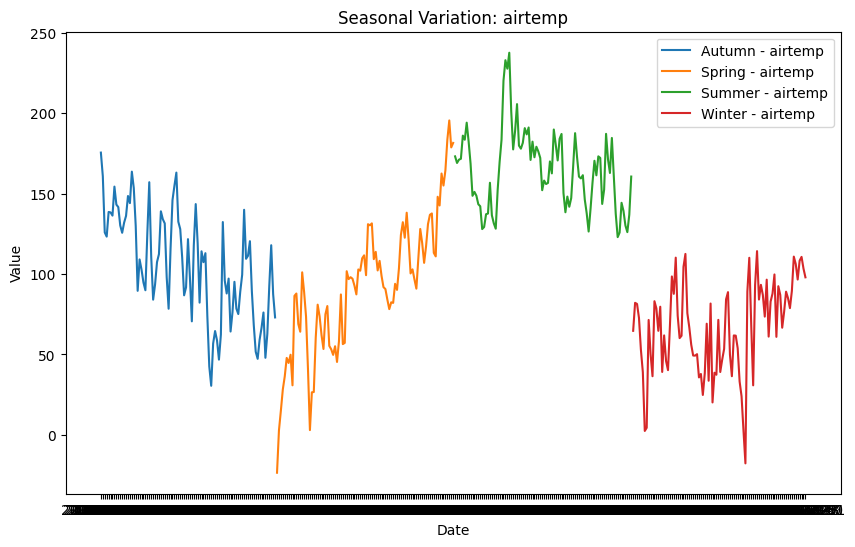

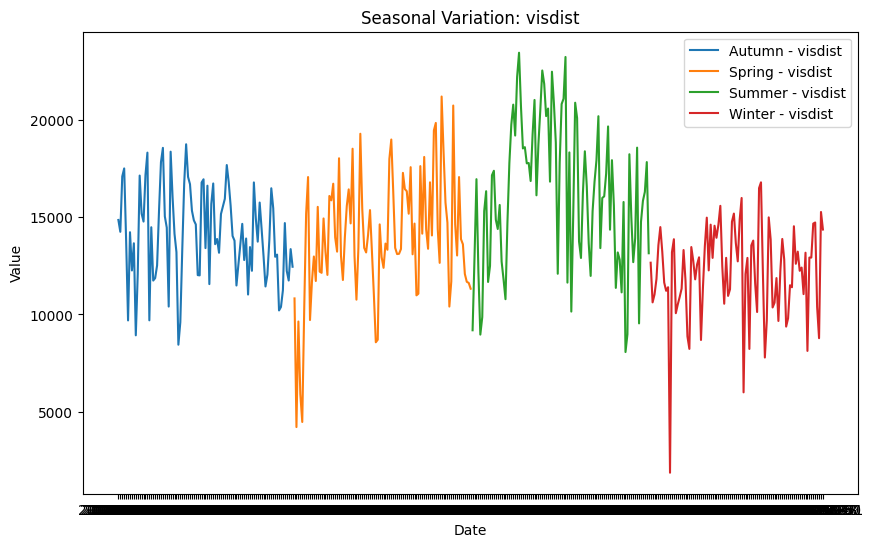

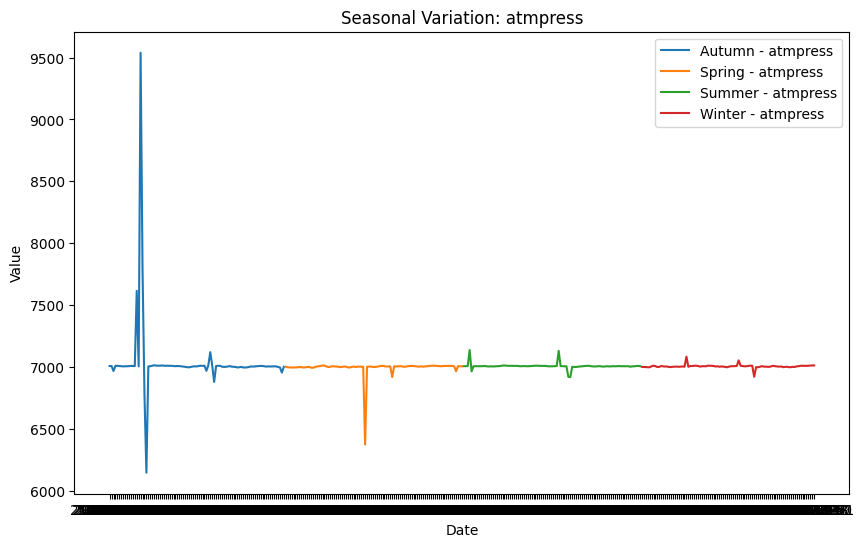

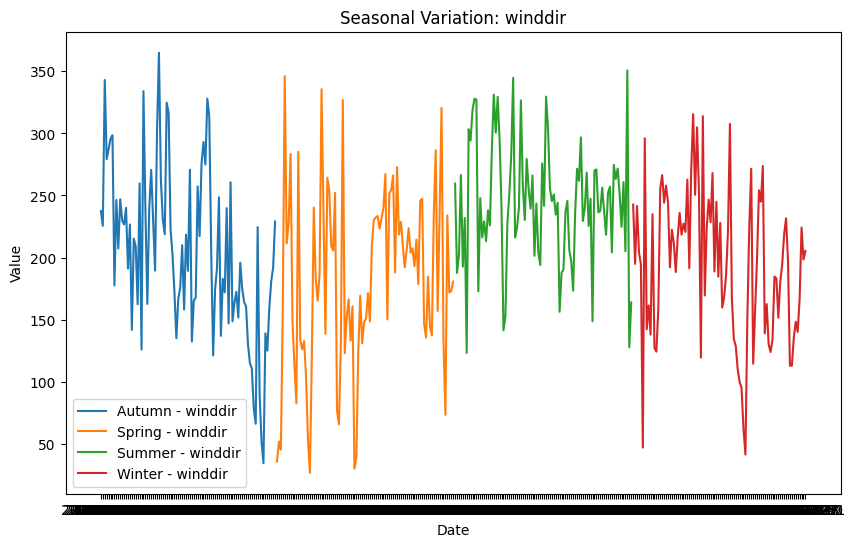

In [0]:
#Plotting
for attribute in ["avg(airtemp)", "avg(visdist)", "avg(atmpress)", "avg(winddir)"]:
    plt.figure(figsize=(10, 6))
    for season in season_day_pd["season"].unique():
        season_data = season_day_pd[season_day_pd["season"] == season]
        plt.plot(season_data["date"], season_data[attribute], label=f"{season} - {attribute.split('(')[1][:-1]}")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.title(f"Seasonal Variation: {attribute.split('(')[1][:-1]}")
    plt.legend()
    plt.show()

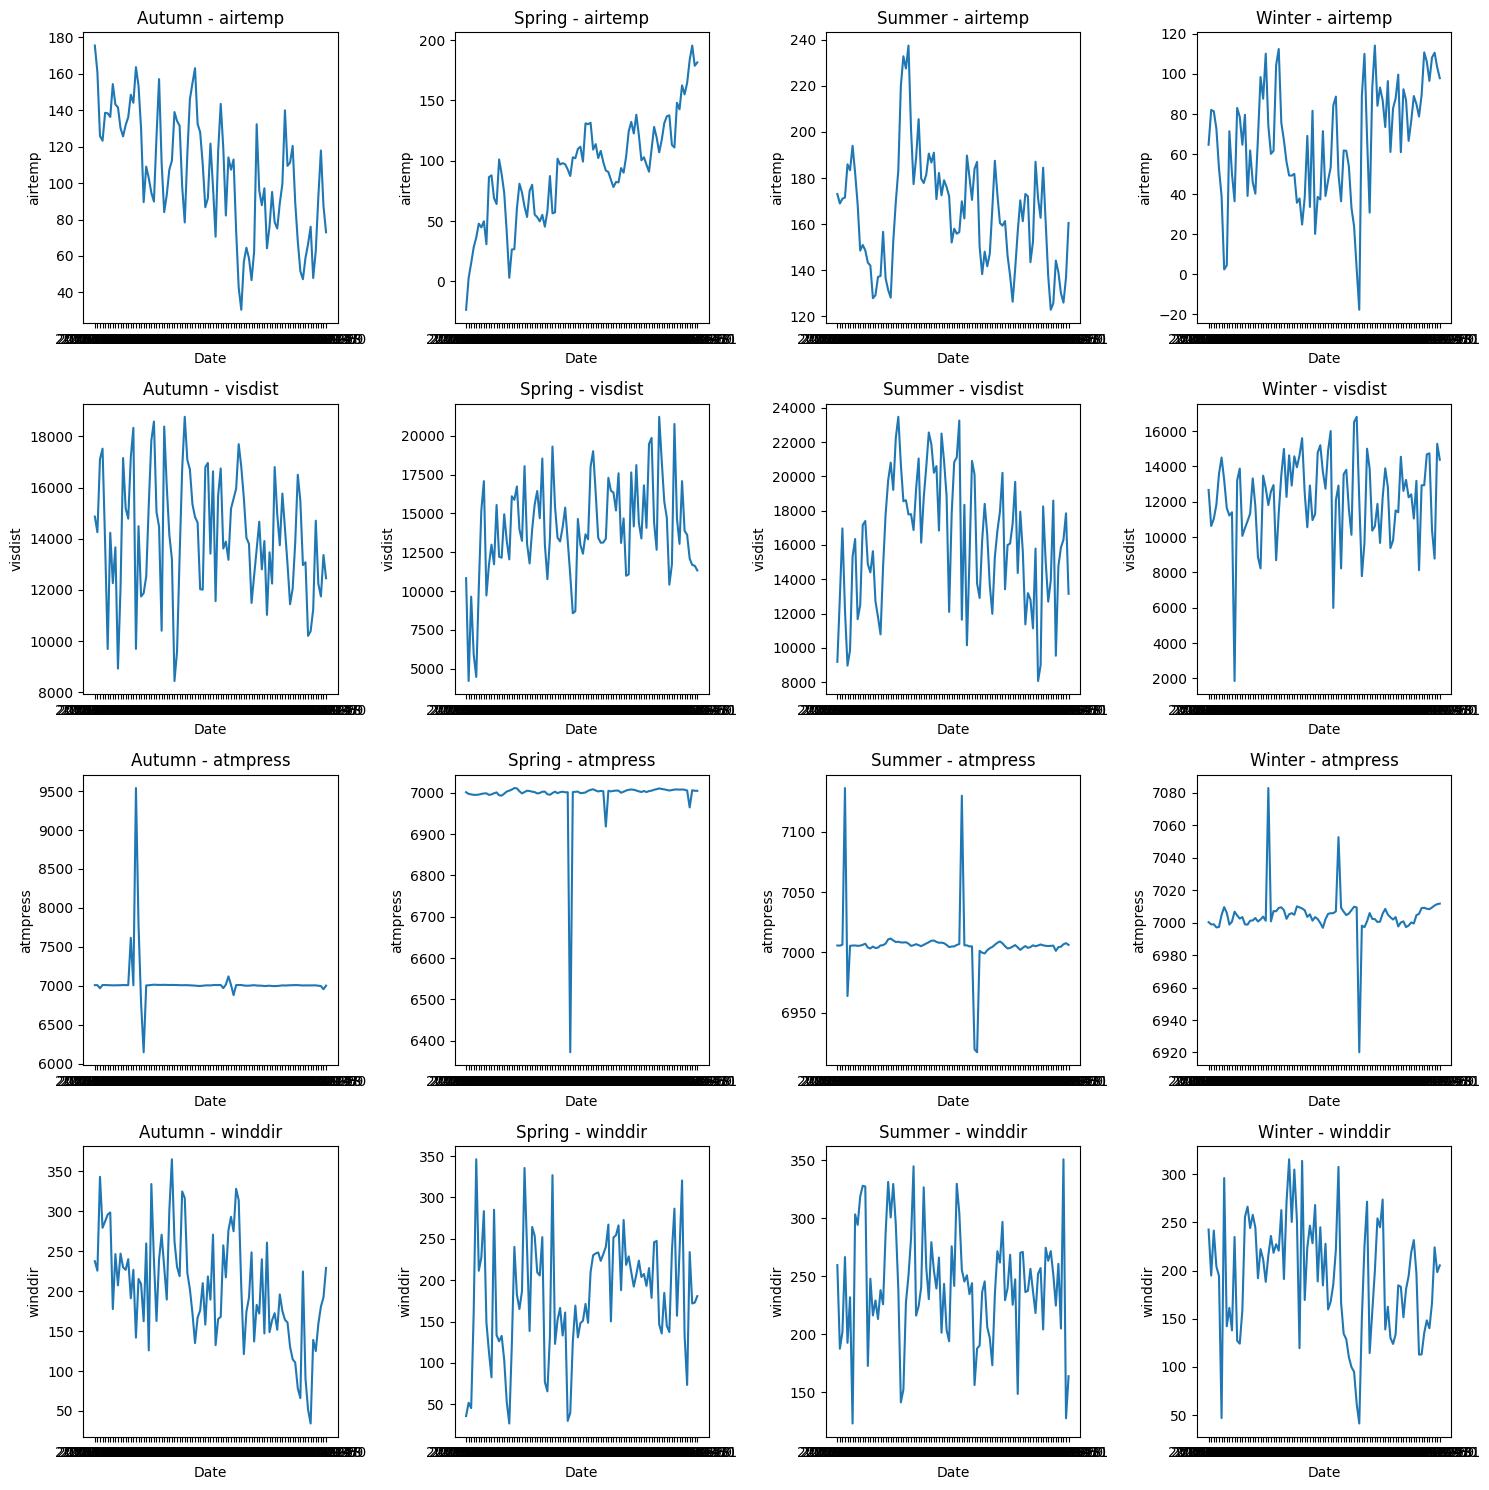

In [0]:
#Subplots of each attributes for each season
attributes = ["avg(airtemp)", "avg(visdist)", "avg(atmpress)", "avg(winddir)"]
seasons = season_day_pd["season"].unique()


fig, axes = plt.subplots(len(attributes), len(seasons), figsize=(15, 15))

# Iterate over attributes
for i, attribute in enumerate(attributes):
    # Iterate over seasons
    for j, season in enumerate(seasons):
        # Filter data for the current attribute and season
        attribute_season_data = season_day_pd[(season_day_pd["season"] == season)]
        
        # Plot the attribute for the current season
        axes[i, j].plot(attribute_season_data["date"], attribute_season_data[attribute])
        axes[i, j].set_xlabel("Date")
        axes[i, j].set_ylabel(f"{attribute.split('(')[1][:-1]}")
        axes[i, j].set_title(f"{season} - {attribute.split('(')[1][:-1]}")

# Adjust layout and display the plots
plt.tight_layout()
plt.show()